In [1]:
import os
import sys
import joblib

import pandas as pd 
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 500
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import imp
import datetime
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# Data Load

In [12]:
word = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', 'version2_dim30.xlsx')) # 이거 어떻게 붙여서 비교해야 할지 몰겟넹 
data = joblib.load(os.path.join('..', '..', '0.Data', '01_제공데이터', 'Thd_FE.pkl'))
locals().update(data)

In [15]:
data["X"].shape, data["y"].shape

((35379, 401), (35379,))

In [17]:
X = data["X"]
y = data["y"]

## z-score feature
* 상품군_표준편차 = 0 : 없음
* 상품군&브랜드_표준편차 = 0 : 1895 (결측값 또한 존재)
* NEW_표준편차 = 0 : 18078 (상품 가격이 동일한 경우)
* **0인 경우 z-score 또한 0 값으로 만들어 주기**

In [16]:
def zscore(price, mean, std) :
    if std == 0 : 
        return 0 
    else : 
        return (price - mean) / std

In [18]:
X["상품군_zscore"] = X.apply(lambda x : zscore(x["판매단가"], x["상품군_평균판매단가"], x["상품군_표준편차"]) , axis = 1)

In [19]:
brand = X.columns[X.columns.str.contains("상품군&브랜드")]

for b in brand : 
    X[b] = X[b].fillna(0)

In [20]:
X["상품군&브랜드_zscore"] = X.apply(lambda x : zscore(x["판매단가"], x["상품군&브랜드_평균판매단가"], x["상품군&브랜드_표준편차"]) , axis = 1)
X["마더코드_zscore"] = X.apply(lambda x : zscore(x["판매단가"], x["마더코드_평균판매단가"], x["마더코드_표준편차"]) , axis = 1)
X["NEW_zscore"] = X.apply(lambda x : zscore(x["판매단가"], x["NEW_평균판매단가"], x["NEW_표준편차"]) , axis = 1)

In [21]:
# z-score 만들어 줬으니 평균, 분산, 표준편차 제거! 
stat_mean = X.columns[X.columns.str.contains("_평균판매단가")]
stat_var = X.columns[X.columns.str.contains("분산")]
stat_std = X.columns[X.columns.str.contains("표준편차")]

In [22]:
stats = [stat_mean, stat_var, stat_std]

for stat in stats : 
    X.drop(stat, axis=1, inplace=True)

## target distribution 

In [24]:
# log(y)
y2 = np.log1p(y)

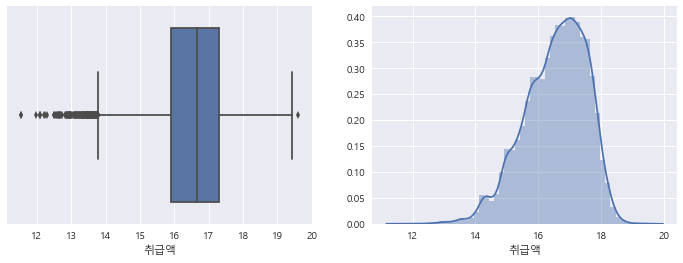

In [25]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(y2, ax=ax1)
sns.distplot(y2, ax=ax2)

# Modeling 

In [26]:
import random

In [27]:
import warnings
warnings.filterwarnings(action='ignore')

In [29]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, train_test_split, GroupShuffleSplit, TimeSeriesSplit

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## LGBM

In [36]:
import lightgbm as lgb

### parameter tuning with Bayesian Optimization 
* loss 이상하게 집어넣어ㅂㅓ림 ...
* score = np.mean([mean_absolute_percentage_error(np.expm1(y_test), y_pred[k]) for k in range(len(y_pred))]) 이렇게 되어야 함 

In [79]:
params_range = {
                'num_leaves': (8, 64),
                'bagging_fraction': (0.8, 1),
                'max_depth': (8, 32),
                'lambda_l1': (0, 5),
                'lambda_l2': (0, 5),
                'min_split_gain': (0.001, 0.1),
                'min_child_weight': (5, 50),
                'learning_rate' : (.02, .05), 
               }

In [83]:
%%time
paramlst = []
scorelst = []


def running(num_leaves, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, learning_rate):
    params = {
    "objective": "regression",
    "boosting": "gbdt",
    'metric': 'mape', 
    "num_leaves": int(round(num_leaves)),
    "learning_rate": learning_rate,
    "bagging_fraction": max(min(bagging_fraction,1),0),
    "max_depth" : int(round(max_depth)),
    "lambda_l1" : max(lambda_l1,0),
    "lambda_l2" : max(lambda_l2,0),
    "min_split_gain": min_split_gain,
    "min_child_weight": min_child_weight,
    "n_jobs" : -1
    }
    
    print(params)
    tscv = TimeSeriesSplit(n_splits=12)
    scores = [] 
    models = []
    
    
    # test set 먼저 뽑기 (train 0.8, test 0.2)
    X_test, Y_test = pd.DataFrame(), pd.DataFrame()

    for i in range(1,13):
        test_idx = random.sample(list(X[X['방송월'] == i].index), int(len(X[X['방송월'] == i]) / 5))

        x_test = X.loc[test_idx]
        y_test = y2.loc[test_idx]

        X_test = pd.concat([X_test, x_test], axis=0)
        Y_test = pd.concat([Y_test, y_test], axis=0)
    
    
    # train, test 재정의 
    x_train = X.drop(X_test.index, axis=0)
    y_train = y2.drop(Y_test.index, axis=0)
    
    x_test = X_test 
    y_test = Y_test[0]
    
    
    
    # TimeSeriesSplit (train, val) 기반 Cross Validation 
    for train_index, val_index in tscv.split(x_train):
        train_X = x_train.iloc[train_index]    
        val_X = x_train.iloc[val_index]
        
        train_y = y_train.iloc[train_index]
        val_y = y_train.iloc[val_index]
        
        lgb_train = lgb.Dataset(train_X.values, train_y.values)
        lgb_eval = lgb.Dataset(val_X.values, val_y.values)
        
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=10000, 
                        valid_sets=(lgb_train, lgb_eval),
                        early_stopping_rounds= 500,
                        verbose_eval=500)
        models.append(gbm)
        del gbm
    
    
    y_pred = []
    y_pred.append([np.expm1(model.predict(x_test.values)) for model in models]) # 12 fold 해서 12번 들어감 
    
    
    score = np.mean([mean_absolute_percentage_error(y_test, y_pred[k]) for k in range(len(y_pred))]) # 이거 잘못 넣어서 값 이상하게 나와버림 ^_^ .. np.expm1(y_test)
    print(score)
    scorelst.append(score)
    paramlst.append(params)
    
    return -mean_absolute_percentage_error(y_test, y_pred)      

    
Baysian = BayesianOptimization(running, params_range, random_state = 0)
Baysian.maximize(init_points = 10, n_iter = 20)

|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
{'objective': 'regression', 'boosting': 'gbdt', 'metric': 'mape', 'num_leaves': 58, 'learning_rate': 0.036346495489906906, 'bagging_fraction': 0.909762700785465, 'max_depth': 18, 'lambda_l1': 3.5759468318620975, 'lambda_l2': 3.0138168803582195, 'min_split_gain': 0.04432113391500656, 'min_child_weight': 34.065235087999525, 'n_jobs': -1}
Training until validation scores don't improve for 500 rounds
[500]	training's mape: 0.0124538	valid_1's mape: 0.0272859
Early stopping, best iteration is:
[232]	training's mape: 0.0125523	valid_1's mape: 0.0272725
Training until validation scores don't improve for 500 rounds
[500]	training's mape: 0.0124517	valid_1's mape: 0.0290837
Early stopping, best iteration is:
[267]	training's mape: 0.0124522	valid_1's mape

In [85]:
# exp 안 씌우고 돌려서 값 겁나 이상하게 나와버림... ㅠㅠ 
print(scorelst)

[119139629.95176825, 120282388.03192817, 118862600.84953497, 119735180.55022238, 119661376.05412057, 119753519.89949343, 120640241.99138659, 118579587.63183504, 119452375.15361437, 119192439.38736993, 117955761.19440845, 118085048.8476495, 120258838.70317358, 117597928.92943563, 119513049.96835876, 118886133.29827255, 119034225.01090376, 118911992.40292212, 119817167.69042736, 119048172.94894597, 118719469.40925933, 118533712.37441948, 118123611.14184046, 119064566.89840026, 118824018.07005149, 121242526.04461755, 119453980.79774992, 118647236.07523218, 119514855.11726837, 120145074.54710644]


In [94]:
for i, res in enumerate(Baysian.res):
    print('Iteration {}: \n\t{}'.format(i, res))

print("\n")    
print('Final result: ', Baysian.max)

Iteration 0: 
	{'target': -119139629.95176825, 'params': {'bagging_fraction': 0.909762700785465, 'lambda_l1': 3.5759468318620975, 'lambda_l2': 3.0138168803582195, 'learning_rate': 0.036346495489906906, 'max_depth': 18.167715184133712, 'min_child_weight': 34.065235087999525, 'min_split_gain': 0.04432113391500656, 'num_leaves': 57.939288043796466}}
Iteration 1: 
	{'target': -120282388.03192817, 'params': {'bagging_fraction': 0.9927325521002058, 'lambda_l1': 1.9172075941288886, 'lambda_l2': 3.958625190413323, 'learning_rate': 0.03586684759258714, 'max_depth': 21.633069466254376, 'min_child_weight': 46.65184872316975, 'min_split_gain': 0.008032569761590808, 'num_leaves': 12.87924078328628}}
Iteration 2: 
	{'target': -118862600.84953497, 'params': {'bagging_fraction': 0.8040436794880652, 'lambda_l1': 4.16309922773969, 'lambda_l2': 3.8907837547492523, 'learning_rate': 0.046100364447404577, 'max_depth': 31.486840213586337, 'min_child_weight': 40.96213538975256, 'min_split_gain': 0.04668645686

In [96]:
params = {'bagging_fraction': 0.9, 'lambda_l1': 1.7, 'lambda_l2': 3.65, 
          'learning_rate': 0.04, 'max_depth': 15.7, 
          'min_child_weight': 33, 'min_split_gain': 0.02, 'num_leaves': 25}

In [98]:
running(**params)

{'objective': 'regression', 'boosting': 'gbdt', 'metric': 'mape', 'num_leaves': 25, 'learning_rate': 0.04, 'bagging_fraction': 0.9, 'max_depth': 16, 'lambda_l1': 1.7, 'lambda_l2': 3.65, 'min_split_gain': 0.02, 'min_child_weight': 33, 'n_jobs': -1}
Training until validation scores don't improve for 500 rounds
[500]	training's mape: 0.0109914	valid_1's mape: 0.0278114
Early stopping, best iteration is:
[275]	training's mape: 0.0109914	valid_1's mape: 0.0278114
Training until validation scores don't improve for 500 rounds
[500]	training's mape: 0.0119671	valid_1's mape: 0.0284
Early stopping, best iteration is:
[385]	training's mape: 0.0119671	valid_1's mape: 0.0284
Training until validation scores don't improve for 500 rounds
[500]	training's mape: 0.0123662	valid_1's mape: 0.0270166
Early stopping, best iteration is:
[484]	training's mape: 0.0124572	valid_1's mape: 0.0270045
Training until validation scores don't improve for 500 rounds
[500]	training's mape: 0.0133796	valid_1's mape: 0.

-119527417.85557601

In [99]:
print(scorelst)

[119139629.95176825, 120282388.03192817, 118862600.84953497, 119735180.55022238, 119661376.05412057, 119753519.89949343, 120640241.99138659, 118579587.63183504, 119452375.15361437, 119192439.38736993, 117955761.19440845, 118085048.8476495, 120258838.70317358, 117597928.92943563, 119513049.96835876, 118886133.29827255, 119034225.01090376, 118911992.40292212, 119817167.69042736, 119048172.94894597, 118719469.40925933, 118533712.37441948, 118123611.14184046, 119064566.89840026, 118824018.07005149, 121242526.04461755, 119453980.79774992, 118647236.07523218, 119514855.11726837, 120145074.54710644, 119527417.85557601]
